In [1]:
import os
import shutil
import time
import random
import math

# from tqdm import tqdm
from tqdm.auto import tqdm
from torchsummary import summary
!pip install -q tensorboardX
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import SubsetRandomSampler
from torch.nn.utils import clip_grad_norm_
from torch.nn import Parameter
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import filterwarnings
filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams['axes.grid'] = False

!pip install -q jupyter-dash
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html

if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print('The number of GPUs available: {}'.format(torch.cuda.device_count()))
device = "cuda" if torch.cuda.is_available() else "cpu" 

     |████████████████████████████████| 124 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 8.4 MB/s 
     |████████████████████████████████| 3.7 MB 78.9 MB/s 
     |████████████████████████████████| 83 kB 2.0 MB/s 
     |████████████████████████████████| 1.8 MB 74.4 MB/s 
     |████████████████████████████████| 357 kB 73.4 MB/s 
Tesla T4
The number of GPUs available: 1


In [2]:
EPOCHS = 30
BATCH_SIZE = 64
LR = 0.01
SEED = 42

In [3]:
def seed_everything(SEED):
  torch.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(SEED)
  random.seed(SEED)
  os.environ['PYTHONHASHSEED'] = str(SEED)
seed_everything(SEED)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.FashionMNIST(root="./dataset", train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, pin_memory=True, num_workers=0, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



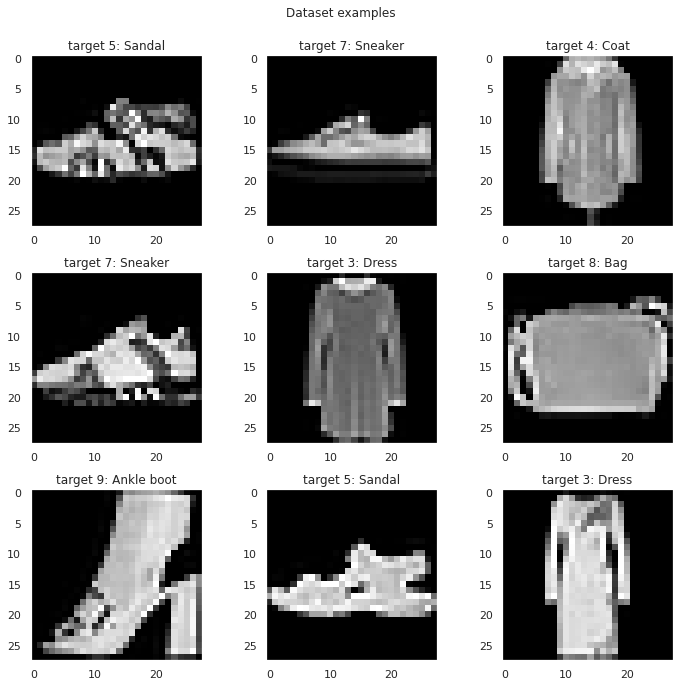

In [5]:
for data, label in train_dataloader:
    break

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i in range(9):
  img = np.transpose(data[i], (1, 2, 0)).squeeze(axis=2)
  ax[i//3][i%3].set_title(f"target {label[i]}: {classes[label[i]]}")
  ax[i//3][i%3].imshow(np.asarray(img), cmap='gray')
fig.suptitle('Dataset examples')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
class ArcFaceNet(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.layers = list()
        self.layers.append(nn.Conv2d(1, 256, 5))
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.MaxPool2d(2))
        self.layers.append(nn.Conv2d(256, 256, 3))
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.MaxPool2d(2))
        self.layers.append(nn.Conv2d(256, 3, 5))
        self.layers.append(nn.AdaptiveAvgPool2d(1))
        
        self.net = nn.Sequential(*self.layers)
        
    def forward(self, x):
        x = self.net(x)
        x = x.view(x.shape[0], 3)
        return x
    
    def get_feature(self, x):
        with torch.no_grad():
            x = self.net(x)
            x = x.view(x.shape[0], 3)
            x = F.normalize(x)
            return x

In [7]:
class SoftMaxNet(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.layers = list()
        self.layers.append(nn.Conv2d(1, 256, 5))
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.MaxPool2d(2))
        self.layers.append(nn.Conv2d(256, 256, 3))
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.MaxPool2d(2))
        self.layers.append(nn.Conv2d(256, 3, 5))
        self.layers.append(nn.AdaptiveAvgPool2d(1))
        
        self.net = nn.Sequential(*self.layers)
        self.fc = nn.Linear(3, 10)
        
    def forward(self, x):
        x = self.net(x)
        x = x.view(x.shape[0], 3)
        x = self.fc(x)
        return x
    
    def get_feature(self, x):
        with torch.no_grad():
            x = self.net(x)
            x = x.view(x.shape[0], 3)
            x = F.normalize(x)
            return x

In [8]:
#from https://github.com/ronghuaiyang/arcface-pytorch/blob/47ace80b128042cd8d2efd408f55c5a3e156b032/models/metrics.py#L10
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.eps = 0.0001
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        # cosine = cosine.clamp(-1. + self.eps, 1. - self.eps) 
        # theta = torch.acos(cosine)
        # phi = torch.where(theta < (math.pi - self.m), torch.cos(theta + self.m), torch.cos(theta) - self.mm)
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0+self.eps, 1-self.eps))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size()).to(device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  
        output *= self.s
        # print(output)

        return output

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    batch_size = target.size(0)
    _, pred = output.topk(1, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    correct_k = correct.reshape(-1).float().sum(0)
    return correct_k.mul_(100.0 / batch_size)

In [10]:
def train(model, data_loader, criterion, feat_ext, optimizer, scheduler, device, epoch):
  epoch_start = time.time()
  trn_losses = AverageMeter()
  trn_acc = AverageMeter()
  model.train()
  n_iters = len(data_loader)
  tq = tqdm(enumerate(data_loader), total=n_iters)
  for step, (inputs, labels) in tq:
    inputs, labels = inputs.to(device), labels.to(device)

    if not feat_ext:
        outputs = model(inputs)
    else:
        features = model(inputs)
        outputs = feat_ext(features, labels)
    clip_grad_norm_(model.parameters(), max_norm=5, norm_type=2)
    loss = criterion(outputs, labels)
    acc = accuracy(outputs, labels)
    trn_losses.update(loss.item(), inputs.size(0))
    trn_acc.update(acc.item(), inputs.size(0))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 100 == 0:
      tq.set_description('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, EPOCHS, step+1, n_iters, trn_losses.avg))
  tq.write(f'----------------Epoch {epoch+1} train finished------------------')
  tq.write('Epoch [{}/{}], Time elapsed: {:.4f}s, Loss: {:.4f}, Acc: {:.4f}, learning rate: {:.4f}'.format(
        epoch+1, EPOCHS, time.time()-epoch_start, trn_losses.avg, trn_acc.avg, optimizer.param_groups[0]["lr"]))
  scheduler.step()
  return trn_losses.avg, trn_acc.avg

In [11]:
model = ArcFaceNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
feat_ext = ArcMarginProduct(3, 10, s=30, m=0.5, easy_margin=False).to(device)
optimizer = optim.Adam([{'params': model.parameters()}, {'params': feat_ext.parameters()}], lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [12]:
writer = SummaryWriter('result-ArcFace')
best_loss = 10e10
tq = tqdm(range(EPOCHS), total=EPOCHS)
for epoch in tq:
  trn_loss, trn_acc = train(model, train_dataloader, criterion, feat_ext, optimizer, scheduler, device, epoch)
  writer.add_scalar('losses/train_loss', trn_loss, epoch+1)
  writer.add_scalar('accs/train_accuracy', trn_acc, epoch+1)
  writer.add_scalar('lr/learning_rate', optimizer.param_groups[0]["lr"], epoch+1)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 1 train finished------------------
Epoch [1/30], Time elapsed: 11.2940s, Loss: 6.0394, Acc: 21.0262, learning rate: 0.0100


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 2 train finished------------------
Epoch [2/30], Time elapsed: 11.0124s, Loss: 3.2180, Acc: 51.5675, learning rate: 0.0100


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 3 train finished------------------
Epoch [3/30], Time elapsed: 11.0741s, Loss: 2.9105, Acc: 57.3372, learning rate: 0.0099


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 4 train finished------------------
Epoch [4/30], Time elapsed: 11.0676s, Loss: 2.7872, Acc: 58.6863, learning rate: 0.0098


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 5 train finished------------------
Epoch [5/30], Time elapsed: 11.1232s, Loss: 2.6978, Acc: 59.6401, learning rate: 0.0096


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 6 train finished------------------
Epoch [6/30], Time elapsed: 11.1701s, Loss: 2.6485, Acc: 60.1738, learning rate: 0.0093


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 7 train finished------------------
Epoch [7/30], Time elapsed: 11.2072s, Loss: 2.5830, Acc: 60.6874, learning rate: 0.0090


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 8 train finished------------------
Epoch [8/30], Time elapsed: 11.2446s, Loss: 2.5461, Acc: 61.0609, learning rate: 0.0087


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 9 train finished------------------
Epoch [9/30], Time elapsed: 11.2464s, Loss: 2.4992, Acc: 61.3811, learning rate: 0.0083


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 10 train finished------------------
Epoch [10/30], Time elapsed: 11.2968s, Loss: 2.4540, Acc: 61.7796, learning rate: 0.0079


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 11 train finished------------------
Epoch [11/30], Time elapsed: 11.3299s, Loss: 2.4232, Acc: 62.0831, learning rate: 0.0075


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 12 train finished------------------
Epoch [12/30], Time elapsed: 11.3473s, Loss: 2.3835, Acc: 62.2582, learning rate: 0.0070


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 13 train finished------------------
Epoch [13/30], Time elapsed: 11.4006s, Loss: 2.3562, Acc: 62.5667, learning rate: 0.0065


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 14 train finished------------------
Epoch [14/30], Time elapsed: 11.3927s, Loss: 2.3151, Acc: 62.9236, learning rate: 0.0060


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 15 train finished------------------
Epoch [15/30], Time elapsed: 11.3796s, Loss: 2.2715, Acc: 63.2621, learning rate: 0.0055


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 16 train finished------------------
Epoch [16/30], Time elapsed: 11.3880s, Loss: 2.2498, Acc: 63.3321, learning rate: 0.0050


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 17 train finished------------------
Epoch [17/30], Time elapsed: 11.4480s, Loss: 2.2031, Acc: 63.7323, learning rate: 0.0045


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 18 train finished------------------
Epoch [18/30], Time elapsed: 11.4302s, Loss: 2.1533, Acc: 64.1009, learning rate: 0.0040


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 19 train finished------------------
Epoch [19/30], Time elapsed: 11.4103s, Loss: 2.1137, Acc: 64.3910, learning rate: 0.0035


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 20 train finished------------------
Epoch [20/30], Time elapsed: 11.4459s, Loss: 2.0760, Acc: 64.8196, learning rate: 0.0030


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 21 train finished------------------
Epoch [21/30], Time elapsed: 11.4648s, Loss: 2.0297, Acc: 65.2498, learning rate: 0.0025


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 22 train finished------------------
Epoch [22/30], Time elapsed: 11.4867s, Loss: 1.9838, Acc: 65.6567, learning rate: 0.0021


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 23 train finished------------------
Epoch [23/30], Time elapsed: 11.4547s, Loss: 1.9453, Acc: 65.9568, learning rate: 0.0017


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 24 train finished------------------
Epoch [24/30], Time elapsed: 11.4593s, Loss: 1.9070, Acc: 66.3887, learning rate: 0.0013


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 25 train finished------------------
Epoch [25/30], Time elapsed: 11.4390s, Loss: 1.8718, Acc: 66.7006, learning rate: 0.0010


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 26 train finished------------------
Epoch [26/30], Time elapsed: 11.4873s, Loss: 1.8404, Acc: 67.0257, learning rate: 0.0007


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 27 train finished------------------
Epoch [27/30], Time elapsed: 11.4618s, Loss: 1.8147, Acc: 67.3059, learning rate: 0.0004


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 28 train finished------------------
Epoch [28/30], Time elapsed: 11.4689s, Loss: 1.7957, Acc: 67.5027, learning rate: 0.0002


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 29 train finished------------------
Epoch [29/30], Time elapsed: 11.4672s, Loss: 1.7819, Acc: 67.6978, learning rate: 0.0001


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 30 train finished------------------
Epoch [30/30], Time elapsed: 11.4262s, Loss: 1.7731, Acc: 67.7828, learning rate: 0.0000


In [13]:
model_softmax = SoftMaxNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_softmax.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [14]:
writer = SummaryWriter('result-Softmax')
best_loss = 10e10
tq = tqdm(range(EPOCHS), total=EPOCHS)
for epoch in tq:
  trn_loss, trn_acc = train(model_softmax, train_dataloader, criterion, None, optimizer, scheduler, device, epoch)
  writer.add_scalar('losses/train_loss', trn_loss, epoch+1)
  writer.add_scalar('accs/train_accuracy', trn_acc, epoch+1)
  writer.add_scalar('lr/learning_rate', optimizer.param_groups[0]["lr"], epoch+1)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 1 train finished------------------
Epoch [1/30], Time elapsed: 10.7873s, Loss: 0.7130, Acc: 76.2907, learning rate: 0.0100


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 2 train finished------------------
Epoch [2/30], Time elapsed: 10.8102s, Loss: 0.4292, Acc: 84.5468, learning rate: 0.0100


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 3 train finished------------------
Epoch [3/30], Time elapsed: 10.7777s, Loss: 0.3959, Acc: 85.7791, learning rate: 0.0099


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 4 train finished------------------
Epoch [4/30], Time elapsed: 10.7342s, Loss: 0.3802, Acc: 86.3861, learning rate: 0.0098


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 5 train finished------------------
Epoch [5/30], Time elapsed: 10.7695s, Loss: 0.3673, Acc: 86.8396, learning rate: 0.0096


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 6 train finished------------------
Epoch [6/30], Time elapsed: 10.7516s, Loss: 0.3568, Acc: 87.0214, learning rate: 0.0093


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 7 train finished------------------
Epoch [7/30], Time elapsed: 10.7361s, Loss: 0.3525, Acc: 87.2916, learning rate: 0.0090


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 8 train finished------------------
Epoch [8/30], Time elapsed: 10.7365s, Loss: 0.3414, Acc: 87.5834, learning rate: 0.0087


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 9 train finished------------------
Epoch [9/30], Time elapsed: 10.6984s, Loss: 0.3339, Acc: 87.9753, learning rate: 0.0083


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 10 train finished------------------
Epoch [10/30], Time elapsed: 10.7085s, Loss: 0.3302, Acc: 88.0553, learning rate: 0.0079


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 11 train finished------------------
Epoch [11/30], Time elapsed: 10.7312s, Loss: 0.3232, Acc: 88.3821, learning rate: 0.0075


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 12 train finished------------------
Epoch [12/30], Time elapsed: 10.6951s, Loss: 0.3183, Acc: 88.4338, learning rate: 0.0070


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 13 train finished------------------
Epoch [13/30], Time elapsed: 10.6840s, Loss: 0.3110, Acc: 88.6406, learning rate: 0.0065


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 14 train finished------------------
Epoch [14/30], Time elapsed: 10.7397s, Loss: 0.3036, Acc: 89.0392, learning rate: 0.0060


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 15 train finished------------------
Epoch [15/30], Time elapsed: 10.6766s, Loss: 0.2967, Acc: 89.3110, learning rate: 0.0055


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 16 train finished------------------
Epoch [16/30], Time elapsed: 10.6802s, Loss: 0.2875, Acc: 89.6395, learning rate: 0.0050


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 17 train finished------------------
Epoch [17/30], Time elapsed: 10.6969s, Loss: 0.2800, Acc: 89.9013, learning rate: 0.0045


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 18 train finished------------------
Epoch [18/30], Time elapsed: 10.7227s, Loss: 0.2721, Acc: 90.1631, learning rate: 0.0040


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 19 train finished------------------
Epoch [19/30], Time elapsed: 10.7573s, Loss: 0.2637, Acc: 90.4332, learning rate: 0.0035


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 20 train finished------------------
Epoch [20/30], Time elapsed: 10.7465s, Loss: 0.2544, Acc: 90.8735, learning rate: 0.0030


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 21 train finished------------------
Epoch [21/30], Time elapsed: 10.7334s, Loss: 0.2478, Acc: 91.0085, learning rate: 0.0025


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 22 train finished------------------
Epoch [22/30], Time elapsed: 10.7083s, Loss: 0.2401, Acc: 91.3287, learning rate: 0.0021


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 23 train finished------------------
Epoch [23/30], Time elapsed: 10.7321s, Loss: 0.2340, Acc: 91.6289, learning rate: 0.0017


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 24 train finished------------------
Epoch [24/30], Time elapsed: 10.7367s, Loss: 0.2253, Acc: 91.9474, learning rate: 0.0013


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 25 train finished------------------
Epoch [25/30], Time elapsed: 10.7532s, Loss: 0.2200, Acc: 92.1575, learning rate: 0.0010


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 26 train finished------------------
Epoch [26/30], Time elapsed: 10.7715s, Loss: 0.2146, Acc: 92.3326, learning rate: 0.0007


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 27 train finished------------------
Epoch [27/30], Time elapsed: 10.7362s, Loss: 0.2087, Acc: 92.5694, learning rate: 0.0004


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 28 train finished------------------
Epoch [28/30], Time elapsed: 10.7396s, Loss: 0.2051, Acc: 92.7811, learning rate: 0.0002


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 29 train finished------------------
Epoch [29/30], Time elapsed: 10.7586s, Loss: 0.2020, Acc: 92.8712, learning rate: 0.0001


  0%|          | 0/937 [00:00<?, ?it/s]

----------------Epoch 30 train finished------------------
Epoch [30/30], Time elapsed: 10.7144s, Loss: 0.2005, Acc: 92.9512, learning rate: 0.0000


In [15]:
def get_samples_vector(model, dataloader, feat_ext, num_samples=1000):
    samples = []
    labels = []
    for x, y in dataloader:
      with torch.no_grad():
          if feat_ext:
              sample = model.get_feature(x.to(device))
          else:
              sample = model(x.to(device))
              sample = F.normalize(sample)
          samples.extend(sample.tolist())
          labels.extend(y.tolist())
          if len(samples) > num_samples:
              break
    return samples, labels

arcloss_samples, arcloss_labels = get_samples_vector(model, train_dataloader, False, 1000)
softmax_samples, softmax_labels = get_samples_vector(model_softmax, train_dataloader, True, 1000)

In [45]:
arc_df = pd.DataFrame(arcloss_samples, columns=['feat1', 'feat2', 'feat3'])
arc_df['labels'] = arcloss_labels
arc_df['labels'].astype('string')
arc_df.head()

,feat1,feat2,feat3,labels
0,0.391582,-0.659095,0.642072,9
1,-0.577522,-0.816330,0.008585,8
2,0.553530,-0.495894,-0.669099,1
3,-0.383508,0.074923,0.920493,5
4,0.148172,0.854084,-0.498583,3


In [46]:
sft_df = pd.DataFrame(softmax_samples, columns=['feat1', 'feat2', 'feat3'])
sft_df['labels'] = softmax_labels
sft_df['labels'].astype('string')
sft_df.head()

,feat1,feat2,feat3,labels
0,-0.022841,0.999516,0.021098,9
1,0.100049,-0.261563,-0.959987,3
2,-0.227407,0.051965,-0.972412,3
3,0.578214,-0.266009,0.771302,8
4,-0.818218,0.531213,-0.219846,1


In [47]:
app = JupyterDash(__name__)

In [49]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]], subplot_titles=("SoftMax", "ArcFace"))
fig.add_trace(go.Scatter3d(x=sft_df.feat1, y=sft_df.feat2, z=sft_df.feat3, mode='markers', 
                 marker=dict(size=2, color=sft_df.labels, opacity=0.7)), row=1, col=1)
fig.add_trace(go.Scatter3d(x=arc_df.feat1, y=arc_df.feat2, z=arc_df.feat3, mode='markers', 
                 marker=dict(size=2, color=arc_df.labels, opacity=0.7)), row=1, col=2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), title_text="toy examples")
app.layout = html.Div([dcc.Graph(figure=fig)])
app.run_server(mode='inline') 

<IPython.core.display.Javascript object>